In [1]:
!nvidia-smi
!pip install -q ultralytics torch torchvision opencv-python pyyaml gradio tqdm


Thu Dec 18 07:39:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# **Upload and Extract Dataset**

In [2]:
from google.colab import files
uploaded = files.upload()


Saving dataset.zip to dataset.zip


In [3]:
import zipfile, os

with zipfile.ZipFile("dataset.zip", "r") as zip_ref:
    zip_ref.extractall("/content")

DATASET_ROOT = "/content/dataset"
print("Dataset path:", DATASET_ROOT)

Dataset path: /content/dataset


# **VERIFY LABELS**

In [4]:
import os

def verify_labels(split="train", source="camera"):
    img_dir = f"{DATASET_ROOT}/images/{split}/{source}"
    lbl_dir = f"{DATASET_ROOT}/labels/{split}/{source}"

    imgs = sorted(os.listdir(img_dir))
    lbls = sorted(os.listdir(lbl_dir))

    print("Images:", len(imgs))
    print("Labels:", len(lbls))
    print("Image example:", imgs[0])
    print("Label example:", lbls[0])

    with open(os.path.join(lbl_dir, lbls[0])) as f:
        print("\nLabel content:\n", f.read())

verify_labels("train", "camera")

Images: 43
Labels: 43
Image example: camera_001.jpg
Label example: camera_001.txt

Label content:
 1 0.5265625 0.515625 0.02734375 0.075
1 0.22265625 0.44765625 0.4453125 0.14609375
1 0.5 0.221875 0.99921875 0.44296875


# **DEFINE CLASSES**

In [5]:
OBJECT_CLASSES = ["person", "car", "animal"]
NUM_CLASSES = len(OBJECT_CLASSES)

SOURCES = ["camera", "cctv", "drone"]

# **CREATE YOLO YAML FILES**

In [6]:
import yaml

def create_yaml(source):
    data = {
        "path": DATASET_ROOT,
        "train": f"images/train/{source}",
        "val": f"images/val/{source}",
        "test": f"images/test/{source}",
        "names": OBJECT_CLASSES
    }
    yaml_path = f"/content/{source}.yaml"
    with open(yaml_path, "w") as f:
        yaml.dump(data, f)
    return yaml_path

CLIENT_YAMLS = {src: create_yaml(src) for src in SOURCES}
CLIENT_YAMLS

{'camera': '/content/camera.yaml',
 'cctv': '/content/cctv.yaml',
 'drone': '/content/drone.yaml'}

# **LOAD YOLO MODEL**

In [7]:
from ultralytics import YOLO

BASE_MODEL = "yolov8n.pt"


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# **LOCAL CLIENT TRAINING**

In [8]:
def train_local(client_name, yaml_path, epochs=20):
    print(f"\nTraining client: {client_name}")

    model = YOLO(BASE_MODEL)

    model.train(
        data=yaml_path,
        epochs=epochs,
        imgsz=640,
        batch=8,
        lr0=1e-3,
        freeze=10,
        device="cpu",
        verbose=True
    )
    return model


# **FEDERATED AVERAGING**

In [9]:
import torch

def federated_average(models):
    global_model = models[0]
    global_state = global_model.model.state_dict()

    for k in global_state.keys():
        global_state[k] = torch.stack(
            [m.model.state_dict()[k].float() for m in models]
        ).mean(0)

    global_model.model.load_state_dict(global_state)
    return global_model

# **FEDERATED TRAINING LOOP**

In [10]:
ROUNDS = 3
LOCAL_EPOCHS = 20

global_model = YOLO(BASE_MODEL)

for r in range(ROUNDS):
    print(f"\n===== Federated Round {r+1} =====")

    local_models = []
    for src in SOURCES:
        local_model = train_local(src, CLIENT_YAMLS[src], epochs=LOCAL_EPOCHS)
        local_models.append(local_model)

    global_model = federated_average(local_models)


===== Federated Round 1 =====

Training client: camera
Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/camera.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, p

# **TEST INFERENCE**


image 1/1 /content/dataset/images/test/camera/camera_test001.jpg: 640x640 (no detections), 87.1ms
Speed: 1.9ms preprocess, 87.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Boxes: ultralytics.engine.results.Boxes object with attributes:

cls: tensor([])
conf: tensor([])
data: tensor([], size=(0, 6))
id: None
is_track: False
orig_shape: (640, 640)
shape: torch.Size([0, 6])
xywh: tensor([], size=(0, 4))
xywhn: tensor([], size=(0, 4))
xyxy: tensor([], size=(0, 4))
xyxyn: tensor([], size=(0, 4))


(np.float64(-0.5), np.float64(639.5), np.float64(639.5), np.float64(-0.5))

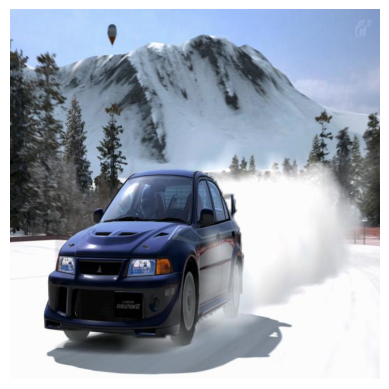

In [11]:
import cv2, matplotlib.pyplot as plt

test_img = f"{DATASET_ROOT}/images/test/camera/" + os.listdir(f"{DATASET_ROOT}/images/test/camera")[0]

results = global_model.predict(test_img, conf=0.15)
print("Boxes:", results[0].boxes)

img = results[0].plot()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")

# **GRADIO DEPLOYMENT**

In [12]:
import gradio as gr

def detect_objects(image):
    results = global_model.predict(
        image,
        conf=0.15,
        iou=0.5
    )
    return results[0].plot()

demo = gr.Interface(
    fn=detect_objects,
    inputs=gr.Image(type="numpy", label="Upload Image"),
    outputs=gr.Image(label="Detected Objects"),
    title="Federated Object Detection on Smart Cameras at the Edge",
    description="YOLOv8 federated model trained across Camera, CCTV, and Drone clients."
)

demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d2813546659a2cd369.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# **SAVE REQUIREMENTS**

In [13]:
with open("requirements.txt", "w") as f:
    f.write("""
torch
torchvision
ultralytics
opencv-python
pyyaml
gradio
tqdm
""")
